In [53]:
import os
import shutil
import numpy as np
import matplotlib.pyplot as plt

import scipy
from PIL import Image
from scipy import ndimage

import torch
import torchvision

from torch import utils
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import datasets, transforms
import torchvision.models as models

import copy
import time

import torch.nn.functional as F

from torchvision import datasets, models, transforms
from torchvision.datasets import ImageFolder

from torch.utils.data import DataLoader,Dataset,ConcatDataset
from torchvision.utils import make_grid


import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from matplotlib.image import imread

import time
from sklearn.model_selection import train_test_split
from tqdm import tqdm


In [54]:


!mkdir /kaggle/working/Grape
!mkdir /kaggle/working/Grape/test
!mkdir /kaggle/working/Grape/train

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

!cp -r /kaggle/input/plant-diseases/dataset_itr2/dataset_itr2/test/Grape* /kaggle/working/Grape/test
!cp -r /kaggle/input/plant-diseases/dataset_itr2/dataset_itr2/train/Grape* /kaggle/working/Grape/train



transfrom = transforms.Compose([
        transforms.RandomResizedCrop(196),
        transforms.ToTensor(),
    ])

train_path='/kaggle/working/Grape/train'
test_path='/kaggle/working/Grape/test'
BATCH_SIZE=32
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
test_dataset=ImageFolder(test_path,transform=transfrom)
train_dataset=ImageFolder(train_path,transform=transfrom)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)

val_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)


# dataset=ImageFolder(path,transform=transfrom)

# train_dataset,test_dataset=train_test_split(dataset,test_size=0.2,shuffle=True,random_state=43)

batch_size = 32
n_iters = 10000
num_epochs = n_iters / (len(train_dataset) / batch_size)

# train_loader = torch.utils.data.DataLoader(dataset = train_dataset, batch_size=batch_size, shuffle=True)

# val_loader = torch.utils.data.DataLoader(dataset = test_dataset, batch_size=batch_size, shuffle=False)

mkdir: cannot create directory ‘/kaggle/working/Grape’: File exists
mkdir: cannot create directory ‘/kaggle/working/Grape/test’: File exists
mkdir: cannot create directory ‘/kaggle/working/Grape/train’: File exists


In [55]:
from torch.autograd import Variable
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.cnn = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=5, stride=1, padding=2)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=2)
        self.cnn2 = nn.Conv2d(in_channels=16, out_channels=8, kernel_size=5, stride=1, padding=2)
        self.relu2 = nn.ReLU()
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)
        self.fc1 = nn.Linear(8*49*49, 4)
        
        
    def forward(self, x):
        out = self.cnn(x)
        out = self.relu(out)
        out = self.maxpool(out)
        out = self.cnn2(out)
        out = self.relu2(out)
        out = self.maxpool2(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        return out
    
model = NeuralNetwork()

model = model.to(device)

criterion = nn.CrossEntropyLoss()
learning_rate = 0.01
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# iter = 0
# for epoch in range(int(num_epochs)):
#     for i, (images, labels) in enumerate(train_loader):
#         images = Variable(images.cuda())
#         labels = Variable(labels.cuda())
        
#         optimizer.zero_grad()
#         outputs = model(images)
#         loss = criterion(outputs, labels)
#         loss.backward()
#         optimizer.step()
        
#         iter += 1
        
#         if iter % 500 == 0:
#             correct = 0
#             total = 0
#             for images, labels in test_loader:
#                 images = Variable(images.cuda())
#                 outputs = model(images)
                
#                 _, predicted = torch.max(outputs.data, 1)
#                 total += labels.size(0)
                
#                 if torch.cuda.is_available():
#                     correct += (predicted.cpu() == labels.cpu()).sum()
#                 else:
#                     correct += (predicted == labels).sum()
                
#             accuracy = 100 * correct / total
#             print('Iteration: {}. Loss {}. Accuracy: {}'.format(iter, loss.data, accuracy))

In [56]:
def train(model,loss_fn,dataloader,optimizer,epoch):
  print('\nEpoch : %d'%epoch)
  
  total_loss=0    
  correct=0
  total=0

  model.train()

  for data in tqdm(dataloader):
    
    inputs,labels=data[0].to(device),data[1].to(device)
    
    outputs=model(inputs)
    
    loss=loss_fn(outputs,labels)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    total_loss += loss.item()
    
    _, predicted = outputs.max(1)
    total += labels.size(0)
    correct += predicted.eq(labels).sum().item()
      
  loss=total_loss/len(dataloader)
  accuracy=100.*correct/total
  
  accuracies['train'].append(accuracy)
  losses['train'].append(loss)
  print('Train Loss: %.3f | Accuracy: %.3f'%(loss,accuracy))

In [57]:
def test(model,loss_fn,dataloader,epoch):
#   model.eval()

  total_loss=0
  correct=0
  total=0

  with torch.no_grad():
    for data in tqdm(dataloader):
      images,labels=data[0].to(device),data[1].to(device)
      
      outputs=model(images)

      loss= loss_fn(outputs,labels)
      total_loss+=loss.item()
      
      _, predicted = outputs.max(1)
      total += labels.size(0)
      correct += predicted.eq(labels).sum().item()
  
  loss=total_loss/len(dataloader)
  accuracy=100.*correct/total

  losses['val'].append(loss)
  accuracies['val'].append(accuracy)

  print('Test Loss: %.3f | Accuracy: %.3f'%(loss,accuracy)) 

In [58]:
model = model.to(device)

loss_fn = nn.CrossEntropyLoss()

optimizer_ft = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [59]:
losses = {'train':[], 'val':[]}
accuracies = {'train':[], 'val':[]}
epochs=30
for epoch in range(1,epochs+1): 
  train(model,loss_fn,train_loader,optimizer_ft,epoch)
  test(model,loss_fn,val_loader,epoch)


Epoch : 1


100%|██████████| 407/407 [00:38<00:00, 10.46it/s]


Train Loss: 1.019 | Accuracy: 52.145


100%|██████████| 102/102 [00:09<00:00, 11.11it/s]


Test Loss: 1.074 | Accuracy: 58.231

Epoch : 2


100%|██████████| 407/407 [00:39<00:00, 10.33it/s]


Train Loss: 0.763 | Accuracy: 65.803


100%|██████████| 102/102 [00:08<00:00, 11.62it/s]


Test Loss: 0.974 | Accuracy: 56.289

Epoch : 3


100%|██████████| 407/407 [00:39<00:00, 10.26it/s]


Train Loss: 0.687 | Accuracy: 70.025


100%|██████████| 102/102 [00:09<00:00, 11.23it/s]


Test Loss: 0.778 | Accuracy: 68.527

Epoch : 4


100%|██████████| 407/407 [00:38<00:00, 10.65it/s]


Train Loss: 0.602 | Accuracy: 74.754


100%|██████████| 102/102 [00:09<00:00, 10.67it/s]


Test Loss: 0.548 | Accuracy: 76.418

Epoch : 5


100%|██████████| 407/407 [00:38<00:00, 10.60it/s]


Train Loss: 0.554 | Accuracy: 77.245


100%|██████████| 102/102 [00:08<00:00, 12.05it/s]


Test Loss: 0.635 | Accuracy: 72.873

Epoch : 6


100%|██████████| 407/407 [00:37<00:00, 10.94it/s]


Train Loss: 0.489 | Accuracy: 80.368


100%|██████████| 102/102 [00:08<00:00, 11.35it/s]


Test Loss: 0.449 | Accuracy: 82.306

Epoch : 7


100%|██████████| 407/407 [00:37<00:00, 10.78it/s]


Train Loss: 0.438 | Accuracy: 82.698


100%|██████████| 102/102 [00:09<00:00, 10.34it/s]


Test Loss: 0.442 | Accuracy: 82.799

Epoch : 8


100%|██████████| 407/407 [00:37<00:00, 11.00it/s]


Train Loss: 0.418 | Accuracy: 83.651


100%|██████████| 102/102 [00:08<00:00, 11.60it/s]


Test Loss: 0.424 | Accuracy: 83.385

Epoch : 9


100%|██████████| 407/407 [00:37<00:00, 10.96it/s]


Train Loss: 0.389 | Accuracy: 84.951


100%|██████████| 102/102 [00:09<00:00, 11.15it/s]


Test Loss: 0.352 | Accuracy: 85.758

Epoch : 10


100%|██████████| 407/407 [00:39<00:00, 10.37it/s]


Train Loss: 0.378 | Accuracy: 85.420


100%|██████████| 102/102 [00:09<00:00, 11.02it/s]


Test Loss: 0.300 | Accuracy: 89.242

Epoch : 11


100%|██████████| 407/407 [00:38<00:00, 10.60it/s]


Train Loss: 0.359 | Accuracy: 86.220


100%|██████████| 102/102 [00:09<00:00, 10.94it/s]


Test Loss: 0.359 | Accuracy: 86.097

Epoch : 12


100%|██████████| 407/407 [00:38<00:00, 10.57it/s]


Train Loss: 1.203 | Accuracy: 80.929


100%|██████████| 102/102 [00:08<00:00, 11.55it/s]


Test Loss: 0.842 | Accuracy: 60.974

Epoch : 13


100%|██████████| 407/407 [00:37<00:00, 10.81it/s]


Train Loss: 0.743 | Accuracy: 66.710


100%|██████████| 102/102 [00:08<00:00, 11.45it/s]


Test Loss: 0.649 | Accuracy: 72.503

Epoch : 14


100%|██████████| 407/407 [00:38<00:00, 10.58it/s]


Train Loss: 0.604 | Accuracy: 75.238


100%|██████████| 102/102 [00:10<00:00, 10.01it/s]


Test Loss: 0.504 | Accuracy: 79.439

Epoch : 15


100%|██████████| 407/407 [00:38<00:00, 10.67it/s]


Train Loss: 0.511 | Accuracy: 79.353


100%|██████████| 102/102 [00:08<00:00, 11.59it/s]


Test Loss: 0.453 | Accuracy: 81.782

Epoch : 16


100%|██████████| 407/407 [00:38<00:00, 10.57it/s]


Train Loss: 0.436 | Accuracy: 82.959


100%|██████████| 102/102 [00:09<00:00, 10.35it/s]


Test Loss: 0.396 | Accuracy: 84.032

Epoch : 17


100%|██████████| 407/407 [00:37<00:00, 10.81it/s]


Train Loss: 0.401 | Accuracy: 84.359


100%|██████████| 102/102 [00:08<00:00, 11.34it/s]


Test Loss: 0.417 | Accuracy: 83.693

Epoch : 18


100%|██████████| 407/407 [00:37<00:00, 10.92it/s]


Train Loss: 0.374 | Accuracy: 85.443


100%|██████████| 102/102 [00:08<00:00, 11.44it/s]


Test Loss: 0.381 | Accuracy: 84.679

Epoch : 19


100%|██████████| 407/407 [00:37<00:00, 10.79it/s]


Train Loss: 0.361 | Accuracy: 86.212


100%|██████████| 102/102 [00:09<00:00, 11.16it/s]


Test Loss: 0.356 | Accuracy: 86.806

Epoch : 20


100%|██████████| 407/407 [00:37<00:00, 10.77it/s]


Train Loss: 0.349 | Accuracy: 86.596


100%|██████████| 102/102 [00:09<00:00, 11.31it/s]


Test Loss: 0.847 | Accuracy: 70.376

Epoch : 21


100%|██████████| 407/407 [00:37<00:00, 10.79it/s]


Train Loss: 0.339 | Accuracy: 86.696


100%|██████████| 102/102 [00:09<00:00, 10.33it/s]


Test Loss: 0.317 | Accuracy: 87.731

Epoch : 22


100%|██████████| 407/407 [00:38<00:00, 10.69it/s]


Train Loss: 0.323 | Accuracy: 87.781


100%|██████████| 102/102 [00:09<00:00, 11.26it/s]


Test Loss: 0.300 | Accuracy: 89.550

Epoch : 23


100%|██████████| 407/407 [00:38<00:00, 10.66it/s]


Train Loss: 0.307 | Accuracy: 88.396


100%|██████████| 102/102 [00:09<00:00, 10.63it/s]


Test Loss: 0.709 | Accuracy: 74.414

Epoch : 24


100%|██████████| 407/407 [00:38<00:00, 10.59it/s]


Train Loss: 0.290 | Accuracy: 89.119


100%|██████████| 102/102 [00:09<00:00, 10.97it/s]


Test Loss: 0.274 | Accuracy: 89.612

Epoch : 25


100%|██████████| 407/407 [00:39<00:00, 10.33it/s]


Train Loss: 0.286 | Accuracy: 89.542


100%|██████████| 102/102 [00:08<00:00, 11.45it/s]


Test Loss: 0.290 | Accuracy: 88.687

Epoch : 26


100%|██████████| 407/407 [00:40<00:00, 10.15it/s]


Train Loss: 0.278 | Accuracy: 89.465


100%|██████████| 102/102 [00:09<00:00, 11.15it/s]


Test Loss: 0.258 | Accuracy: 90.321

Epoch : 27


100%|██████████| 407/407 [00:37<00:00, 10.79it/s]


Train Loss: 0.264 | Accuracy: 90.065


100%|██████████| 102/102 [00:09<00:00, 11.20it/s]


Test Loss: 0.268 | Accuracy: 89.550

Epoch : 28


100%|██████████| 407/407 [00:37<00:00, 10.75it/s]


Train Loss: 0.272 | Accuracy: 89.711


100%|██████████| 102/102 [00:09<00:00, 10.69it/s]


Test Loss: 0.261 | Accuracy: 90.413

Epoch : 29


100%|██████████| 407/407 [00:38<00:00, 10.57it/s]


Train Loss: 0.271 | Accuracy: 89.603


100%|██████████| 102/102 [00:09<00:00, 11.10it/s]


Test Loss: 1.013 | Accuracy: 70.561

Epoch : 30


100%|██████████| 407/407 [00:38<00:00, 10.51it/s]


Train Loss: 0.260 | Accuracy: 90.218


100%|██████████| 102/102 [00:09<00:00, 10.33it/s]

Test Loss: 0.238 | Accuracy: 91.030


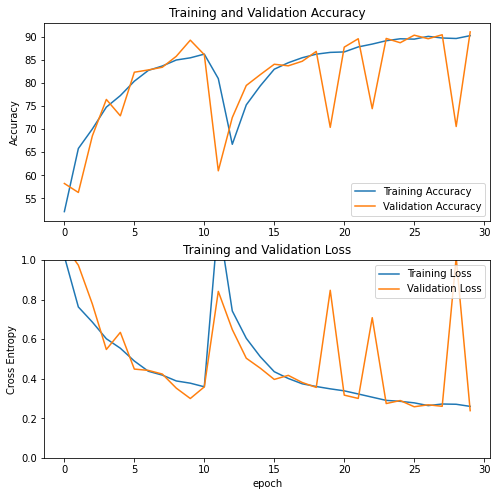

In [60]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(accuracies['train'], label='Training Accuracy')
plt.plot(accuracies['val'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
# plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(losses['train'], label='Training Loss')
plt.plot(losses['val'], label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()